In [42]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import pickle
plt.style.use("ggplot")

In [3]:
def rootdir(*args):
    return os.path.join("..", *args)

def datadir(*args):
    return rootdir("data", *args)

In [4]:
ground_truth = {
    "period": 3.5,
    "t0": 1.3,
    "us": [0.5, 0.2],
    "r": 0.03,
    "a": 10,
    "yerr": 1e-4
}

In [36]:
# load juliet outputs
with open(datadir("juliet", "generated_data_100ppm", "_dynesty_NS_posteriors.pkl"), "rb") as fh:
    juliet_results = pickle.load(fh)

var_map = {"period": "P_p1", "t0": "t0_p1", "r": "p_p1", "a": "a_p1"}
nsamps = len(juliet_results["posterior_samples"]["P_p1"])
juliet_samples = {k: juliet_results["posterior_samples"][k2] for k, k2 in var_map.items()}
juliet_samples["us"] = np.empty((1, nsamps, 2))
# have to manually apply triangular bijection (😞)
q1 = juliet_results["posterior_samples"]["q1_fake"]
q2 = juliet_results["posterior_samples"]["q2_fake"]
juliet_samples["us"][0, :, 0] = np.sqrt(q1) * 2 * q2
juliet_samples["us"][0, :, 1] = np.sqrt(q1) * (1 - 2 * q2)

In [78]:
# load exofast data
exofast_results = pd.read_csv(datadir("exofast", "generated_100ppm", "generated_100ppm.mcmc.csv"))
var_names = ["period", "t0", "r", "a", "yerr"]
exofast_samples = {k: exofast_results[k].values for k in var_names}
exofast_samples["us"] = exofast_results[["u1", "u2"]].values.reshape(1, -1, 2)

In [79]:
traces = {
    "exoplanet+NUTS": az.InferenceData.from_netcdf(datadir("exoplanet+NUTS_trace.nc")),
    "exoplanet+MH": az.InferenceData.from_netcdf(datadir("exoplanet+MH_trace.nc")),
    "batman+MH": az.InferenceData.from_netcdf(datadir("batman+MH_trace.nc")),
    "pytransit+MH": az.InferenceData.from_netcdf(datadir("pytransit+MH_trace.nc")),
    "juliet+NS": az.convert_to_inference_data(juliet_samples),
    "exofastv2+MH": az.convert_to_inference_data(exofast_samples),
}

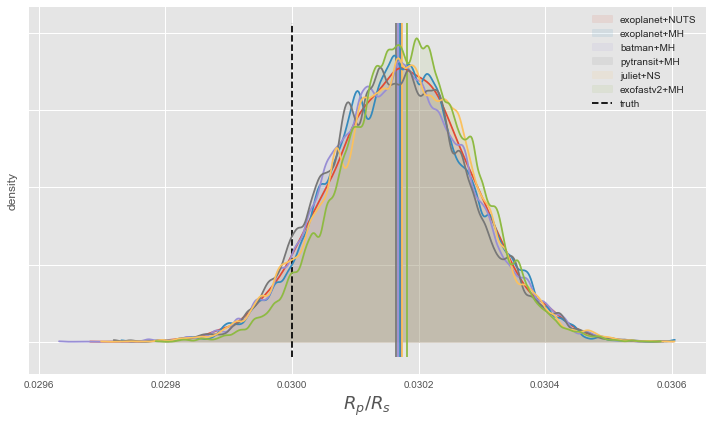

In [80]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, (name, trace) in enumerate(traces.items()):
    az.plot_kde(trace["posterior"]["r"], fill_kwargs={"alpha": 0.1}, label=name, plot_kwargs={"color": f"C{i}"}, ax=ax)

# rsum = np.mean([trace["posterior"]["r"].sum() for trace in traces.values()])
# ax.fill_between(np.linspace(0.01, 0.1, 100), rsum/(0.1 - 0.01), 0, color="r", alpha=0.1, label="prior")
ylims = ax.get_ylim()
ax.vlines(ground_truth["r"], *ylims, color="k", ls="--", label="truth", zorder=1)
for i, trace in enumerate(traces.values()):
    ax.vlines(np.median(trace["posterior"]["r"]), *ylims, color=f"C{i}")

ax.legend()
ax.set_xlabel("$R_p/R_s$", fontsize=18)
ax.set_ylabel("density")
# ax.set_xlim(0.029634691246069225, 0.0306508438078696)
ax.set_yticklabels([])
plt.tight_layout()

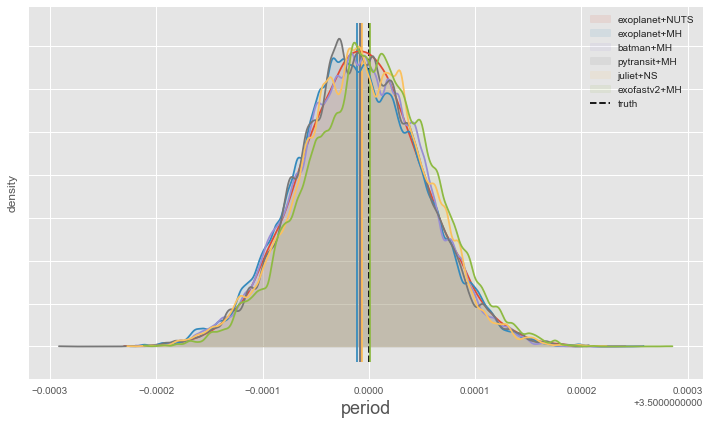

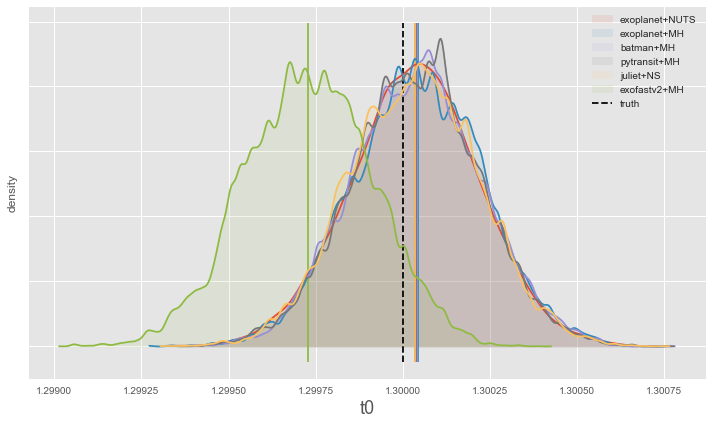

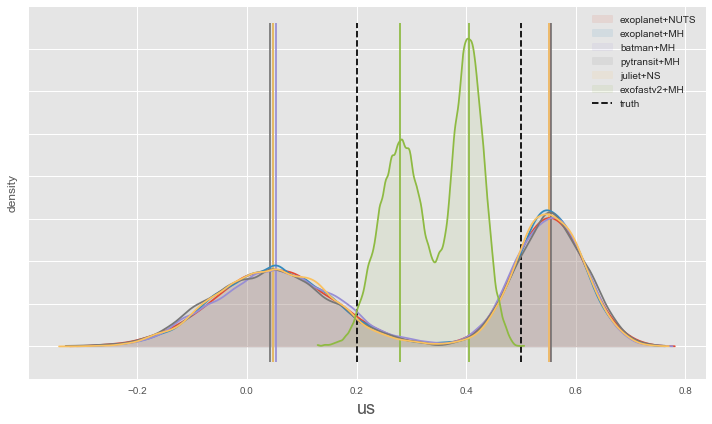

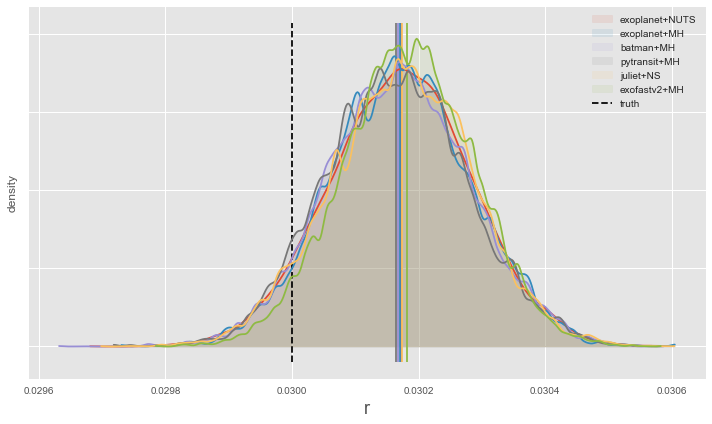

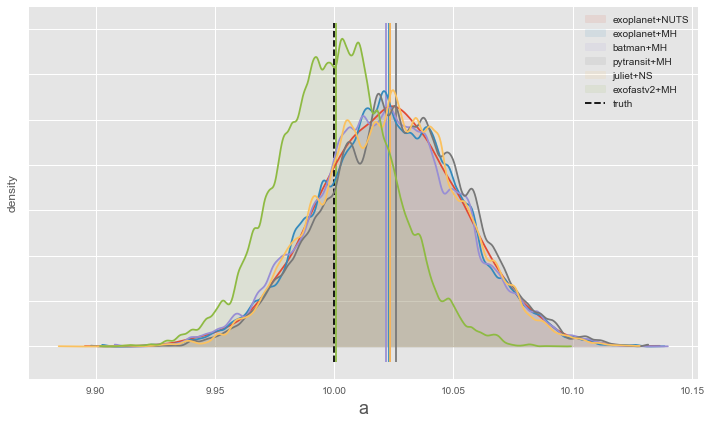

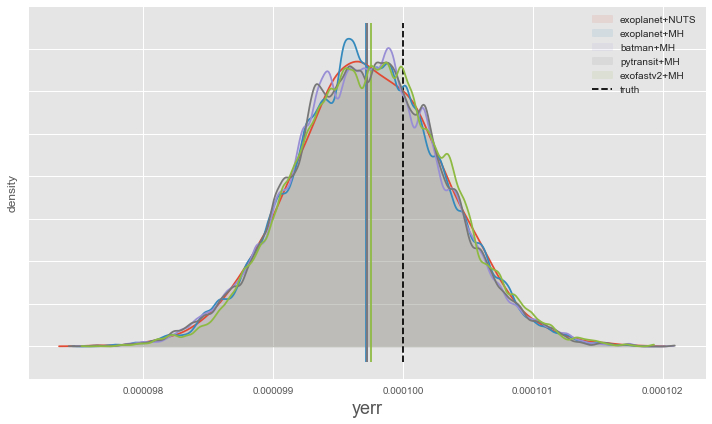

In [81]:
for param in ground_truth.keys():
    fig, ax = plt.subplots(figsize=(10, 6))

    for i, (name, trace) in enumerate(traces.items()):
        if param == "yerr" and name == "juliet+NS": continue
        az.plot_kde(trace["posterior"][param], fill_kwargs={"alpha": 0.1}, label=name, plot_kwargs={"color": f"C{i}"}, ax=ax)

    # rsum = np.mean([trace["posterior"][param].sum() for trace in traces.values()])
    # ax.fill_between(np.linspace(0.01, 0.1, 100), rsum/(0.1 - 0.01), 0, color="r", alpha=0.1, label="prior")
    ylims = ax.get_ylim()
    ax.vlines(ground_truth[param], *ylims, color="k", ls="--", label="truth", zorder=1)
    for i, (name, trace) in enumerate(traces.items()):
        if param == "yerr" and name == "juliet+NS": continue
        if param == "us":
            ax.vlines(np.median(trace["posterior"][param], axis=(0, 1)), *ylims, color=f"C{i}")
        else:
            ax.vlines(np.median(trace["posterior"][param]), *ylims, color=f"C{i}")

    ax.legend()
    ax.set_xlabel(param, fontsize=18)
    ax.set_ylabel("density")
    # ax.set_xlim(0.029634691246069225, 0.0306508438078696)
    ax.set_yticklabels([])
    plt.tight_layout()

In [ ]:
with np.load(datadir("generated_data_100ppm.npz")) as data:
    t = data["t"]
    flux = data["flux"]
with np.load(datadir("generated_data.npz")) as data:
    trueflux = data["flux"]

In [ ]:
preds = [np.median(trace["posterior"]["y"], axis=(0, 1)) for trace in traces.values()]

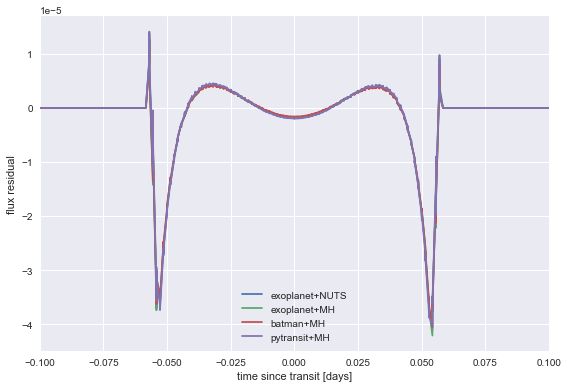

In [ ]:
# Plot the folded data
x_fold = (t - ground_truth["t0"] + 0.5 * ground_truth["period"]) % ground_truth["period"] - 0.5 * ground_truth["period"]
maxphase = 0.1
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < maxphase]
# Plot the folded model residuals
for i, (name, pred) in enumerate(zip(traces, preds)):
    # lq, md, hq = pred
    # plt.plot(x_fold[inds], md[inds]/ trueflux[inds] - 1, color=f"C{i}", label=name)
    # plt.fill_between(x_fold[inds], lq[inds]/ trueflux[inds] - 1, hq[inds]/ trueflux[inds] - 1, color=f"C{i}", alpha=0.1)
    plt.plot(x_fold[inds], pred[inds] - trueflux[inds], color=f"C{i}", label=name)
    # plt.fill_between(x_fold[inds], lq[inds] - trueflux[inds], hq[inds] - trueflux[inds], color=f"C{i}", alpha=0.1)

plt.legend()
plt.xlim(-maxphase, maxphase)
plt.xlabel("time since transit [days]")
plt.ylabel("flux residual")
plt.tight_layout()